Biodiversity in US National Parks
Project Scope

1. How many species per category? 
2. Break-down of categories per conservation status
3. Which category is most likely to be endangered?
4. Statistically significant differences between categories
5. Which park has the most % of observations for protected animals?
6. Observations per conservation status.

In [86]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import itertools

In [87]:
#creating dataframes
species_info = pd.read_csv('species_info.csv',encoding='utf-8')
species_info.drop_duplicates(keep='first', inplace=True)
observations = pd.read_csv('observations.csv',encoding='utf-8')
observations.drop_duplicates(keep='first', inplace=True)

### Inspecting 'species_info.csv'

'species_info.csv' consists pf 5824 entries and describes animals and plants by listing their (1) category, (2) scientific name, (3) common name(s) and (4) their conservation status. Some initial insights:
* the conservation status has a lot of null values
* some scientific names are duplicated (5541 unique scientific names vs. 5824 entries in the dataset)

In [88]:
print('##################################')
print('General info:')
print(species_info.info())
print('##################################')
print('Column names and data types:')
print(species_info.dtypes)
print('##################################')
print('Number of rows and columns:')
print(species_info.shape)
print('##################################')
print('Conservation status values:')
print(species_info.conservation_status.unique())
print('##################################')
print('Animal/plant categories:')
print(species_info.category.unique())
print('##################################')
print('How many animals/plants')
print(len(observations.scientific_name.unique()))
print('##################################')
print('Sample of the dataframe:')
species_info.head()


##################################
General info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 5824 entries, 0 to 5823
Data columns (total 4 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   category             5824 non-null   object
 1   scientific_name      5824 non-null   object
 2   common_names         5824 non-null   object
 3   conservation_status  191 non-null    object
dtypes: object(4)
memory usage: 227.5+ KB
None
##################################
Column names and data types:
category               object
scientific_name        object
common_names           object
conservation_status    object
dtype: object
##################################
Number of rows and columns:
(5824, 4)
##################################
Conservation status values:
[nan 'Species of Concern' 'Endangered' 'Threatened' 'In Recovery']
##################################
Animal/plant categories:
['Mammal' 'Bird' 'Reptile' 'Amphibian' 'Fis

,category,scientific_name,common_names,conservation_status
0,Mammal,Clethrionomys gapperi gapperi,Gapper's Red-Backed Vole,NaN
1,Mammal,Bos bison,"American Bison, Bison",NaN
2,Mammal,Bos taurus,"Aurochs, Aurochs, Domestic Cattle (Feral), Dom...",NaN
3,Mammal,Ovis aries,"Domestic Sheep, Mouflon, Red Sheep, Sheep (Feral)",NaN
4,Mammal,Cervus elaphus,Wapiti Or Elk,NaN


According to the information provided along with the dataset, the missing information about the conservation status denotes the species is of no concern. The nan values have thus been filled as "Species of no concern". Additionally, the conservation status values have been reorganized into ordered categories with "Endangared" at the bottom and "Species of no concern" at the top.

In [89]:
#filling in nans
species_info['conservation_status'] = species_info['conservation_status'].fillna('Species of no concern')

#creating categorical data out of conservation status
species_info["conservation_status"] = species_info["conservation_status"].astype("category")
species_info["conservation_status"] = species_info["conservation_status"].cat.reorder_categories(['Endangered', 'Threatened', 'In Recovery', 'Species of Concern', 'Species of no concern'], ordered=True)

#checking uniques
print(species_info.conservation_status.unique())

['Species of no concern', 'Species of Concern', 'Endangered', 'Threatened', 'In Recovery']
Categories (5, object): ['Endangered' < 'Threatened' < 'In Recovery' < 'Species of Concern' < 'Species of no concern']


The duplicated scientific names are due to inconsistent use of common names, as seen below.

In [90]:
#creating a temporary 'duplicate' column to indicate a duplicated entry
species_info['duplicate'] = species_info.duplicated(subset=['scientific_name'],keep=False)
#creating a temporary df with only duplicate entries
species_info_dup = species_info[species_info.duplicate == True].reset_index()
#dropping the duplicate column from the main df
species_info.drop(labels='duplicate', axis=1, inplace=True)
species_info_dup.sort_values(by='scientific_name', inplace=True, ascending=False)
#checking a few duplicated entries
species_info_dup.head(10)

,index,category,scientific_name,common_names,conservation_status,duplicate
319,3347,Vascular Plant,Zizia aptera,"Heartleaf Alexanders, Heart-Leaf Alexanders, M...",Species of no concern,True
56,632,Vascular Plant,Zizia aptera,Golden Alexanders,Species of no concern,True
441,4290,Vascular Plant,Vulpia octoflora,"Eight-Flower Six-Weeks Grass, Pullout Grass, S...",Species of no concern,True
233,2331,Vascular Plant,Vulpia octoflora,Annual Fescue,Species of no concern,True
232,2330,Vascular Plant,Vulpia myuros,Rattail Fescue,Species of no concern,True
555,5643,Vascular Plant,Vulpia myuros,"Foxtail Fescue, Rattail Fescue, Rat-Tail Fescu...",Species of no concern,True
554,5640,Vascular Plant,Vulpia bromoides,"Brome Fescue, Brome Six-Weeks Grass, Desert Fe...",Species of no concern,True
231,2329,Vascular Plant,Vulpia bromoides,Fescue,Species of no concern,True
37,328,Bird,Vireo solitarius,"Blue-Headed Vireo, Solitary Vireo",Species of no concern,True
297,3231,Bird,Vireo solitarius,Blue-Headed Vireo,Species of no concern,True


These entries will be dropped by ordering them according to their conservation status, so that the entry with the "lowest" status remains and other instances of the same scientific name are dropped.

In [91]:
species_info.sort_values(by='conservation_status', inplace=True, ascending=True)
species_info.drop_duplicates(subset='scientific_name', keep='first', inplace=True)

Additionally, two new columns will be added to the dataframe to facilitate further analysis: a Kingdom column indicating whether the species belongs to the Animal or Plant kingdom; an IsProtected column indicating whether the species falls under any of the conservation status values other than "Species of no concern".

In [92]:
def kingdom_check(x):
    if x in ['Vascular Plant', 'Nonvascular Plant']:
        return 'Plant'
    else:
        return 'Animal'
species_info['Kingdom'] = species_info.category.apply(kingdom_check)
species_info['IsProtected'] = species_info.conservation_status != 'Species of no concern'
species_info.head()

,category,scientific_name,common_names,conservation_status,Kingdom,IsProtected
72,Mammal,Glaucomys sabrinus coloratus,"Carolina Northern Flying Squirrel, Northern Fl...",Endangered,Animal,True
4505,Bird,Gymnogyps californianus,California Condor,Endangered,Animal,True
570,Fish,Noturus baileyi,Smoky Madtom,Endangered,Animal,True
4601,Amphibian,Rana sierrae,Sierra Nevada Yellow-Legged Frog,Endangered,Animal,True
2497,Vascular Plant,Geum radiatum,"Mountain Avens, Spreading Avens",Endangered,Plant,True


### Inspecting 'observations.csv'

'observations.csv' lists sightings of individual species including (1) their scientific name, (2) the park name that reported the sightings, (3) the total number of reported sightings (i.e. observations) for the given entry. No modifications of the dataset are necessary.

In [93]:
#taking a first look at the observations df
print('##################################')
print('General info:')
print(observations.info())
print('##################################')
print('Column names and data types:')
print(observations.dtypes)
print('##################################')
print('Number of rows and columns:')
print(observations.shape)
print('##################################')
print('List park names')
print(observations.park_name.unique())
print('##################################')
print('The number of unique scientific_names is equal between the two DFs:')
print(len(species_info.scientific_name.unique())==len(observations.scientific_name.unique()))
print('##################################')
print('Sample of the DF:')
observations.head()


##################################
General info:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 23281 entries, 0 to 23295
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   scientific_name  23281 non-null  object
 1   park_name        23281 non-null  object
 2   observations     23281 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 727.5+ KB
None
##################################
Column names and data types:
scientific_name    object
park_name          object
observations        int64
dtype: object
##################################
Number of rows and columns:
(23281, 3)
##################################
List park names
['Great Smoky Mountains National Park' 'Yosemite National Park'
 'Bryce National Park' 'Yellowstone National Park']
##################################
The number of unique scientific_names is equal between the two DFs:
True
##################################
Sample of the DF:


,scientific_name,park_name,observations
0,Vicia benghalensis,Great Smoky Mountains National Park,68
1,Neovison vison,Great Smoky Mountains National Park,77
2,Prunus subcordata,Yosemite National Park,138
3,Abutilon theophrasti,Bryce National Park,84
4,Githopsis specularioides,Great Smoky Mountains National Park,85


# Analysis
## Species per category

As seen in the data break-down below, Vascular Plants amount to 76.9% of all species in the dataset. The second most common category is the Bird which constitutes 8.8% of all species in the dataset, while the least common are Amphibians (1.43%) and Reptiles (1.4%).

In [94]:
species_info.shape[0]
species_grouping = species_info.groupby('category').size().reset_index()
species_grouping.columns= ['category', 'Count']
species_grouping['Percentage'] = species_grouping.Count / species_info.shape[0] * 100
species_grouping

,category,Count,Percentage
0,Amphibian,79,1.425735
1,Bird,488,8.807075
2,Fish,125,2.255910
3,Mammal,176,3.176322
4,Nonvascular Plant,333,6.009746
5,Reptile,78,1.407688
6,Vascular Plant,4262,76.917524


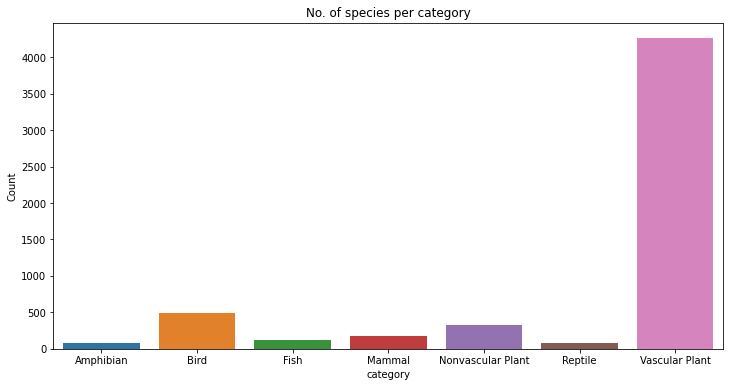

<Figure size 432x288 with 0 Axes>

In [95]:
plt.figure(figsize=(12,6))
plt.title('No. of species per category')
sns.barplot(data=species_grouping, x="category", y='Count')
plt.show()
plt.clf()

Considering only the animal kingdom from the dataset, Birds represent 51.6% of all animal species in the dataset, followed by Mammals (18.6%), Fish (13.2%), Amphibians (8.4%) and Reptiles (8.2%).

In [96]:
species_grouping_animals = species_info[species_info.Kingdom =='Animal'].groupby('category').size().reset_index()
species_grouping_animals.columns= ['category', 'Count']
species_grouping_animals['Percentage'] = species_grouping_animals.Count / species_info[species_info.Kingdom =='Animal'].shape[0] * 100
species_grouping_animals

,category,Count,Percentage
0,Amphibian,79,8.350951
1,Bird,488,51.585624
2,Fish,125,13.213531
3,Mammal,176,18.604651
4,Reptile,78,8.245243


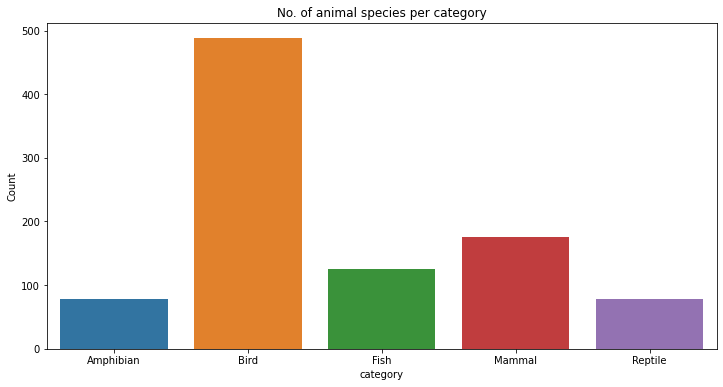

<Figure size 432x288 with 0 Axes>

In [97]:
plt.figure(figsize=(12,6))
plt.title('No. of animal species per category')
sns.barplot(data=species_grouping_animals, x="category", y='Count')
plt.show()
plt.clf()

## Categories per conservation status

The break-down below summarizes the percentage of protected species out of all species from the given category. As seen below, mammals are most likely to be placed under protection as 17% of all mammals from the dataset are considered protected species. Birds are second, with 15.3% of species under protection. On the other hand, only 1% of vascular plants from the dataset are protected.

In [98]:
species_grouping = species_info.groupby(['category','IsProtected']).scientific_name.nunique().reset_index()\
                        .pivot(columns='IsProtected',
                                      index='category',
                                      values='scientific_name')\
                        .reset_index()
species_grouping.columns = ['Category', 'Not Protected', 'Protected']
species_grouping['% of protected'] = species_grouping.Protected / (species_grouping.Protected + species_grouping['Not Protected']) * 100

species_grouping

,Category,Not Protected,Protected,% of protected
0,Amphibian,72,7,8.860759
1,Bird,413,75,15.368852
2,Fish,114,11,8.800000
3,Mammal,146,30,17.045455
4,Nonvascular Plant,328,5,1.501502
5,Reptile,73,5,6.410256
6,Vascular Plant,4216,46,1.079305


A more detailed break-down, where specific conservation status is displayed can be seen below:

In [99]:
#needed to bring back the object category to the conservation status
species_info["conservation_status"] = species_info["conservation_status"].astype("object")
cat_per_cons_status = species_info[species_info.conservation_status != 'Species of no concern']\
    .groupby(["conservation_status", "category"])['scientific_name']\
    .count()\
    .unstack()

cat_per_cons_status

category,Amphibian,Bird,Fish,Mammal,Nonvascular Plant,Reptile,Vascular Plant
conservation_status,,,,,,,
Endangered,1.0,4.0,3.0,6.0,NaN,NaN,1.0
In Recovery,NaN,3.0,NaN,NaN,NaN,NaN,NaN
Species of Concern,4.0,68.0,4.0,22.0,5.0,5.0,43.0
Threatened,2.0,NaN,4.0,2.0,NaN,NaN,2.0


Text(0.5, 1.0, 'Conservation status and category break down')

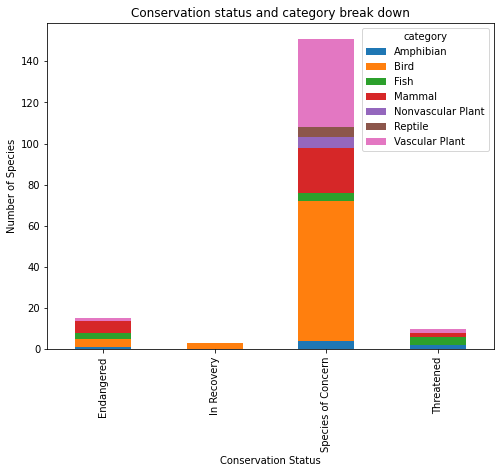

In [100]:
ax = cat_per_cons_status.plot(kind = 'bar', figsize=(8,6), 
                               stacked=True)
ax.set_xlabel("Conservation Status")
ax.set_ylabel("Number of Species")
ax.set_title('Conservation status and category break down')

## Statistical significance

This section will run some chi-squared tests to see if different species have statistically significant differences in conservation status rates. Below are the results of running a contigency table for every combination of categories and their protected/not protected species counts.
It appears that significant differences in the number of protected species are detected between each animal category and each plant category (e.g. amphibians and nonvascular plants; mammals and vascular plants, etc.), which is not surprising considering the relatively low % of protected species reported for plants when compared to animals.
Significant differences within the animal kingdom were detected between mammals and reptiles. This is a strong indication that mammals are stastistically more likely to be under protection than reptiles.

In [101]:
for i in list(itertools.combinations(species_grouping.Category, 2)):
    contingency1 = [[species_grouping['Protected'][species_grouping.Category == i[0]].item(), species_grouping['Not Protected'][species_grouping.Category == i[0]].item()],
                 [species_grouping['Protected'][species_grouping.Category == i[1]].item(), species_grouping['Not Protected'][species_grouping.Category == i[1]].item()]]
    chi, p_value, x1, x2 = chi2_contingency(contingency1)
    if p_value > 0.05:
        print(f'{i[0]}s and {i[1]}s DID NOT have significant difference in conservation percentage')
    else:
        print(f'{i[0]}s and {i[1]}s EXHIBIT statistically significant difference in conservation percentage')
    
    


Amphibians and Birds DID NOT have significant difference in conservation percentage
Amphibians and Fishs DID NOT have significant difference in conservation percentage
Amphibians and Mammals DID NOT have significant difference in conservation percentage
Amphibians and Nonvascular Plants EXHIBIT statistically significant difference in conservation percentage
Amphibians and Reptiles DID NOT have significant difference in conservation percentage
Amphibians and Vascular Plants EXHIBIT statistically significant difference in conservation percentage
Birds and Fishs DID NOT have significant difference in conservation percentage
Birds and Mammals DID NOT have significant difference in conservation percentage
Birds and Nonvascular Plants EXHIBIT statistically significant difference in conservation percentage
Birds and Reptiles DID NOT have significant difference in conservation percentage
Birds and Vascular Plants EXHIBIT statistically significant difference in conservation percentage
Fishs and

## Analysis of park observations

The two datasets are merged for the purposes of further analysis.

In [102]:
all_data = pd.merge(
    left = observations,
    right = species_info,
    left_on = 'scientific_name',
    right_on = 'scientific_name',
    how='left')


print(all_data.info())
all_data.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23281 entries, 0 to 23280
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   scientific_name      23281 non-null  object
 1   park_name            23281 non-null  object
 2   observations         23281 non-null  int64 
 3   category             23281 non-null  object
 4   common_names         23281 non-null  object
 5   conservation_status  23281 non-null  object
 6   Kingdom              23281 non-null  object
 7   IsProtected          23281 non-null  bool  
dtypes: bool(1), int64(1), object(6)
memory usage: 1.4+ MB
None


,scientific_name,park_name,observations,category,common_names,conservation_status,Kingdom,IsProtected
0,Vicia benghalensis,Great Smoky Mountains National Park,68,Vascular Plant,"Purple Vetch, Reddish Tufted Vetch",Species of no concern,Plant,False
1,Neovison vison,Great Smoky Mountains National Park,77,Mammal,American Mink,Species of no concern,Animal,False
2,Prunus subcordata,Yosemite National Park,138,Vascular Plant,Klamath Plum,Species of no concern,Plant,False
3,Abutilon theophrasti,Bryce National Park,84,Vascular Plant,Velvetleaf,Species of no concern,Plant,False
4,Githopsis specularioides,Great Smoky Mountains National Park,85,Vascular Plant,Common Bluecup,Species of no concern,Plant,False


The four distinct distributions on the histogram below correspond to the observations from the four parks in the dataset. This indicates that the Yellowstone National Park has reported higher numbers under observations than the other parks, even though all parks have a very similar number of unique species reported in the dataset (ranging between 5818 and 5823).

['Great Smoky Mountains National Park' 'Yosemite National Park'
 'Bryce National Park' 'Yellowstone National Park']


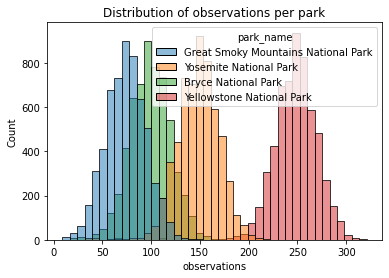

,Park Name,No. of unique species
0,Bryce National Park,5823
1,Great Smoky Mountains National Park,5818
2,Yellowstone National Park,5819
3,Yosemite National Park,5821


<Figure size 432x288 with 0 Axes>

In [103]:
#check the shape of observations
print(all_data.park_name.unique())
sns.histplot(data=all_data, x='observations', hue='park_name')
plt.title('Distribution of observations per park')
plt.show()
plt.clf()

#Number of unique species per park
species_per_park = all_data.drop(["scientific_name", "category", "common_names", "conservation_status", "Kingdom", "IsProtected"], axis = 1).groupby('park_name').count().reset_index()
species_per_park.columns = ['Park Name', 'No. of unique species']
species_per_park


The distribution of the total number of observations between the parks corresponds to the distribution of mean number of observations between the parks and the distribution of observations of protected animals, as seen on the three charts below.

                             Park Name  Total no. of observations
0                  Bryce National Park                     575901
1  Great Smoky Mountains National Park                     431378
2            Yellowstone National Park                    1442314
3               Yosemite National Park                     862836


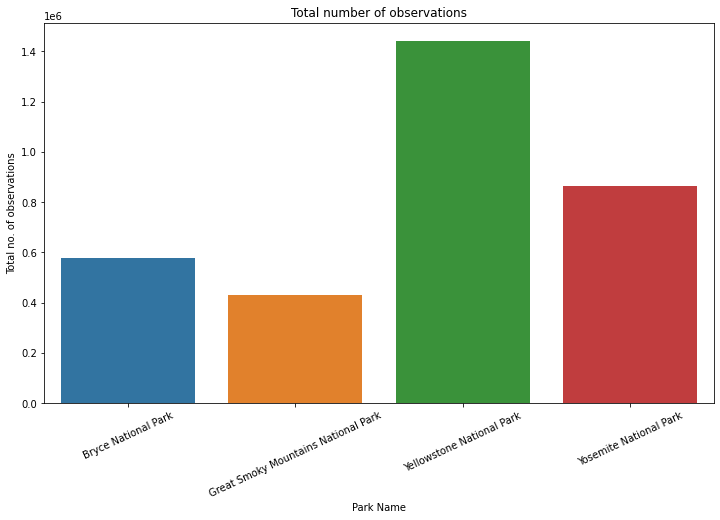

                             Park Name  Mean no. of observations
0                  Bryce National Park                 98.901082
1  Great Smoky Mountains National Park                 74.145411
2            Yellowstone National Park                247.862863
3               Yosemite National Park                148.228139


<Figure size 432x288 with 0 Axes>

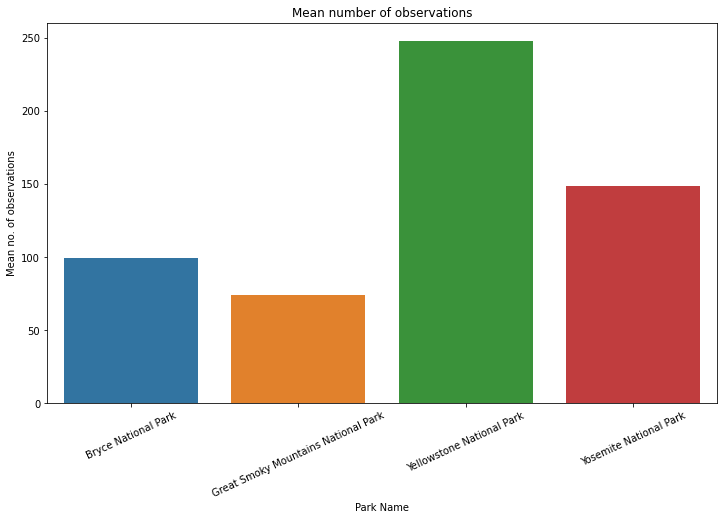

                             Park Name  Protected animals observations  \
0                  Bryce National Park                           11579   
1  Great Smoky Mountains National Park                            7954   
2            Yellowstone National Park                           28150   
3               Yosemite National Park                           16871   

   Total no. of observations  % of protected observations  
0                     575901                     1.970961  
1                     431378                     1.810476  
2                    1442314                     1.914362  
3                     862836                     1.917798  


<Figure size 432x288 with 0 Axes>

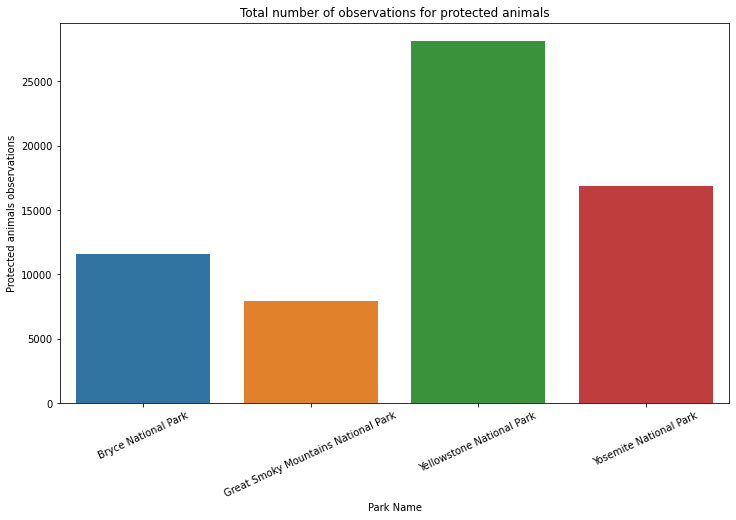

<Figure size 432x288 with 0 Axes>

In [108]:

#total no. of observations
df_sums = observations.drop("scientific_name", axis = 1).groupby("park_name").sum().reset_index()
df_sums.columns = ['Park Name', 'Total no. of observations']
print(df_sums)
plt.figure(figsize=(12,7))
sns.barplot(data=df_sums, x="Park Name", y='Total no. of observations')
plt.title('Total number of observations')
plt.xticks(rotation = 25)
plt.show()
plt.clf()


#mean no. of observations
df_means = observations.drop("scientific_name", axis = 1).groupby("park_name").mean().reset_index()
df_means.columns = ['Park Name', 'Mean no. of observations']
print(df_means)
plt.figure(figsize=(12,7))
sns.barplot(data=df_means, x="Park Name", y='Mean no. of observations')
plt.title('Mean number of observations')
plt.xticks(rotation = 25)
plt.show()
plt.clf()


#total no. of observations of protected animals per park
protected_animals = all_data[(all_data.Kingdom == 'Animal')&(all_data.IsProtected == True)]
df_counts = protected_animals.drop(["scientific_name", "conservation_status", "category", "Kingdom", "IsProtected"], axis = 1).groupby("park_name").sum().reset_index()
df_counts.columns = ['Park Name', 'Protected animals observations']
df_new = pd.merge(
    left = df_counts,
    right = df_sums,
    left_on = 'Park Name',
    right_on = 'Park Name',
    how='left')
df_new['% of protected observations'] = df_new['Protected animals observations'] / (df_new['Protected animals observations'] + df_new['Total no. of observations']) * 100
print(df_new)
plt.figure(figsize=(12,7))
sns.barplot(data=df_counts, x="Park Name", y='Protected animals observations')
plt.title('Total number of observations for protected animals')
plt.xticks(rotation = 25)
plt.show()
plt.clf()


The violin plots below illustrate the relationship between the conservation status and the distribution of observations. One might assume that as the conservation status is less severe, the observations would increase. The plots below confirm that assumption: the Endangered status has mean observations value of 41, while the Species of no Concern has the highest mean of 143 observations.

               Park Name  Mean observations
0             Endangered          41.147059
1            In Recovery         116.000000
2     Species of Concern         128.228261
3  Species of no concern         143.131568
4             Threatened          75.886364


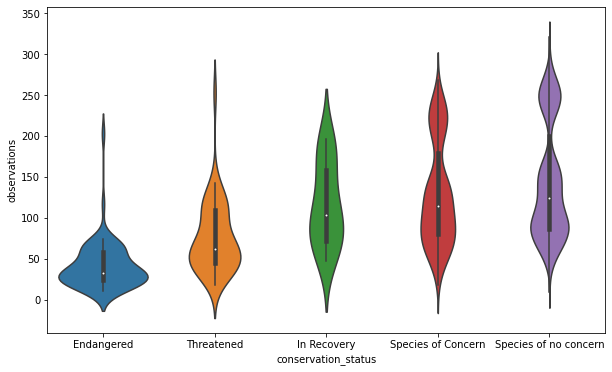

In [105]:
#check relationship between status and observations
df_means = all_data.drop(["scientific_name", "park_name", "category", "Kingdom", "IsProtected"], axis = 1).groupby("conservation_status").mean().reset_index()
df_means.columns = ['Park Name', 'Mean observations']
print(df_means)


plt.figure(figsize=(10,6))
sns.violinplot(x='conservation_status', y='observations', data = all_data, order=['Endangered', 'Threatened', 'In Recovery', 'Species of Concern', 'Species of no concern'])
plt.show()


## Conclusions

How many species per category?
In the analyzed dataset there were 79 Amphibians, 488 birds, 125 fish, 176 mammals, 333 nonvascular plants, 78 reptiles and 4262 vascular plants.

Break-down of categories per conservation status:
mammals are most likely to be placed under protection as 17% of all mammals from the dataset are considered protected species. Birds are second, with 15.3% of species under protection. On the other hand, only 1% of vascular plants from the dataset are protected.

Which category is most likely to be endangered?
Mammals.

Statistically significant differences between categories:
It appears that significant differences in the number of protected species are detected between each animal category and each plant category (e.g. amphibians and nonvascular plants; mammals and vascular plants, etc.), which is not surprising considering the relatively low % of protected species reported for plants when compared to animals.
Significant differences within the animal kingdom were detected between mammals and reptiles. This is a strong indication that mammals are stastistically more likely to be under protection than reptiles.

Which park has the most % of observations for protected animals?
All parks have a similar % of observations of protected animals with Bryce National Park having the highest % (1.97%) and Great Smoky Mountains National Park the lowest (1.81%)

